# Using SentencePiece


| Rubric | Criteria |
| :---: | :---: |
| 1. Was the process of building a model using SentencePiece completed successfully? | Were corpus analysis, preprocessing, SentencePiece application, and tokenizer implementation all completed without omission? |
| 2. Does the Tokenizer built with SentencePiece work in conjunction with an NLP model? | The Text Classifier model with the SentencePiece tokenizer converged properly and achieved over 80% test accuracy. |
| 3. Was the experiment to find the optimal SentencePiece model conducted properly? | The relationship between vocab_size and test accuracy was explored, and the optimal vocab_size was identified and justified. |


In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import konlpy

%matplotlib inline

In [2]:
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


In [3]:
os.listdir('nsmc')

['raw',
 'ratings_train.txt',
 'README.md',
 'ratings.txt',
 'synopses.json',
 '.git',
 'ratings_test.txt',
 'code']

## Step 1. Load Data


In [4]:
import pandas as pd
naver_df = pd.read_table("nsmc/"+"ratings.txt")

naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [5]:
print('데이터 개수 :', len(naver_df))

데이터 개수 : 200000


## Handle Duplicate Data and Missing Values


In [6]:
origin_len = len(naver_df)

In [7]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [8]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [9]:
print('결측치 제거 후 데이터 개수 :', len(naver_df))  

결측치 제거 후 데이터 개수 : 199992


In [10]:
cleaned_corpus = naver_df.drop_duplicates(['document']) 

In [11]:
print('중복 제거 후 데이터 개수 :', len(cleaned_corpus))

중복 제거 후 데이터 개수 : 194543


In [12]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(cleaned_corpus)) 
print('전처리 후 남은 데이터 양(%)', (len(cleaned_corpus)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [13]:
cleaned_corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [14]:
naver_review = cleaned_corpus['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_31/1743548021.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


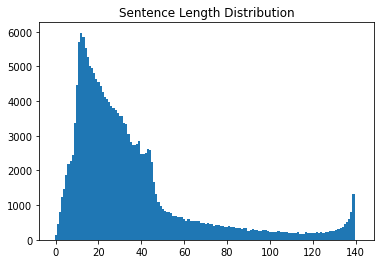

In [15]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [16]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return 

check_sentence_with_length(naver_review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

In [17]:
# sentence_length[문장 길이] = 갯수 
# idx = 문장길이 , _sum = 해당 문장 길이인 문장의 개수 

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135 초과하는 문장 길이를 추출
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


In [18]:
check_sentence_with_length(naver_review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [19]:
check_sentence_with_length(naver_review, 10)

내용이너무좋아요.ㅎ
뀰잼이다뀰잼이라구여
13살이엇냐?...
알파치노 연기때문에
이물감. 시 같았다
매력적인 영화...
이거 재밌는데...
.겁쟁이페달보고싶다
한국 영화치고 좋다
정말 멋진 결말!ㅎ
너무 잘 봣어요..
도라에몽 최고~!!
정말 재밋내요..굿
너무끔찍하네요ㅜㅜㅜ
유지태 너무 멌있다
진짜..쩔지..ㅜㅜ
개꿀재밋다뿌잉최고임
박보영 나와서 추천
그냥 재밌습니다^^
카이키는차캤습니다.
이거왜청불임????
소재가 새로웠던..
이거완전 추전!~~
1236547890
평점이왜이래....
조용하고 잔잔한영화
왜안 저스티스리그요
영화의매력에빠졌어요
피터팬너무좋아요ㅠㅠ
엄청재밌어요정의성굳
계속 울었다..ㅜㅜ
재밋다 그외는 없고
재미나요~귀여워요~
내가본한국최고의애니
인간은 자유의 노예
만세!!!!짱재밌음
아날로그적 감성..
완전 재밌다 ㅋㅋㅋ
유덕화아저씨잘생겼다
통일호 화장실 강추
구르재매맴잼잼잼잼젬
아직까지도 여운이.
스크림보다 재밌네!
좋았다.(열자..)
지극히 붉은 영화.
이거죠~이거!!!!
여운이너무많이남아요
스티브잡스가생각나요
제시카 알바 좋아요
정말 잘 만든 사극
나쁘지많은않은...
재밌네 이거 ㅋㅋㅋ
난 너무 재밌엇음~
보.고.싶.다.!!
즐겁게 볼수있었던!
Very good!
여자 걸그룹이 이쁨
7.32 라니 ㅋㅋ
전편 다보고싶다..
좋다~~ 사랑스러운
진짜감동이다감동이야
나는 재미있게 봤다
애니의새로운 개척점
감동이 있는 이야기
재미있게 봤어요^^
가나다라마바사아자차
좋아요정말좋아요정말
엄청재밌어요꼭보세요
정말 잘 만들어졌음
넝쿨째굴러온당신짱!
야하지만 좀 재밌다
정말대단한거같다는ㅋ
굿굿굿굿굯굿굿굿귯귯
이것도 꽤 명작이지
최고의 영화중 한편
잔잔한 멋이 있네요
겁나재밌었음!!!!
내인생최고의액션영화
감동의 물결....
볼만함~재밋음~굿굿
정말재밌게잘봤습니다
장근석존잘박신혜존예
솔직히 재밌다 ㅋㅋ
늘 감동이었네요..
배울점이많은영화ㅋㅋ
일주일만에 다봣다.
재미있게 본 영화~
멋지고 감동적이다.
너무 좋은 영화예요
이영아 넘 이뻐^^
붉은매다시보고싶다.

Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_31/925258780.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


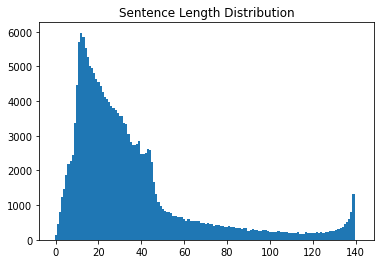

In [20]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거
print("Data Size:", len(naver_review)) 

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [22]:
below_threshold_len(36, naver_review)  # 평균
below_threshold_len(140, naver_review)  # 최장 
below_threshold_len(70, naver_review)  # 중앙값
below_threshold_len(50, naver_review)  
below_threshold_len(60, naver_review) 

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 70 이하인 샘플의 비율: 88.66523082300571
전체 샘플 중 길이가 50 이하인 샘플의 비율: 82.05640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962


/tmp/ipykernel_31/3128022684.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


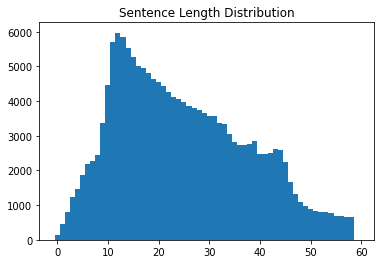

In [23]:
max_len = 60   
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.

filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]


filtered_corpus = [] 
filtered_label = []  
for row, label in zip(naver_df['document'], naver_df['label']):    
    if (len(row) < max_len):     
        filtered_corpus.append(row)  
        filtered_label.append(label)   
        
# 2. # 데이터프레임 조건부 슬라이싱 
train_data = cleaned_corpus[cleaned_corpus['document'].str.len() < max_len]   



sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [24]:
print('전처리 전 데이터 개수 :', len(naver_df))
print('전처리 후 데이터 개수 :', len(train_data))
print('전처리 후 남은 데이터 양(%)', (len(train_data)/len(naver_df))*100)

전처리 전 데이터 개수 : 199992
전처리 후 데이터 개수 : 166401
전처리 후 남은 데이터 양(%) 83.20382815312612


## Step 2. Train SentencePiece Model

- SentencePiece trains a segmentation model with a fixed final vocab size.
- SentencePiece can learn a language-independent subword model from input sentences (assumed Unicode) to generate vocabulary models that handle OOV (Out-of-Vocabulary) words. (It functions as both a tokenizer and detokenizer because it handles both encoding and decoding.)
- It is fast enough to learn directly from raw text, and for languages like Chinese and Japanese that do not use spaces, it provides a method to learn subwords by treating the input as a sequence of Unicode characters.

**SentencePiece supports two subword segmentation algorithms:**

| Algorithm | Description |
| --- | --- |
| BPE (Byte Pair Encoding) | Starts with all characters as a vocabulary, then iteratively merges the most frequent character pairs to form subwords |
| Unigram | Starts with a large vocabulary and iteratively removes tokens that least affect the overall likelihood, resulting in a compact vocabulary |


In [25]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# vocab size=8000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --vocab_size={}'.format(temp_file, vocab_size)    
)


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=kor_spm_bpe_16k --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: kor_spm_bpe_16k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 

In [26]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_unigram_4k*
!ls -l kor_spm_unigram_16k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_bpe_16k*

-rw-r--r-- 1 root root 375096 Mar 18 15:24 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144435 Mar 18 15:24 kor_spm_unigram_8k.vocab
ls: cannot access 'kor_spm_unigram_4k*': No such file or directory
ls: cannot access 'kor_spm_unigram_16k*': No such file or directory
-rw-r--r-- 1 root root 370378 Mar 18 04:02 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root 115580 Mar 18 04:02 kor_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 375093 Mar 19 00:42 kor_spm_bpe_16k.model
-rw-r--r-- 1 root root 144435 Mar 19 00:42 kor_spm_bpe_16k.vocab


In [27]:
vocab_list = pd.read_csv('kor_spm_bpe_16k.vocab', sep='\t', header=None)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.27463
4,.,-3.47852
5,..,-4.24637
6,▁영화,-4.42651
7,이,-4.44480
8,...,-4.48456
9,가,-4.71341


In [28]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 7774


,0,1
1796,▁훨,-9.39465
2627,▁안됨,-9.74119
3325,▁전설의,-9.96349
5641,▁대박이다,-10.59400
845,h,-8.76420
5924,봤네,-10.69010
2328,▁찍은,-9.62319
6040,40,-10.71710
1091,▁버,-8.98071
2882,꾸,-9.83187


In [54]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('영화 존잼 한번더 볼꺼임..')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('영화 존잼 한번더 볼꺼임..',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [55]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')


print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

print('kor_spm_bpe_16k')
test_performance(model='kor_spm_bpe_16k.model')

kor_spm_unigram_8k
[6, 6560, 5609, 184, 659, 109, 5]
['▁영화', '▁존잼', '▁한번더', '▁볼', '꺼', '임', '..']
영화 존잼 한번더 볼꺼임..
kor_spm_bpe_8k
[5, 337, 6421, 5428, 88, 6718, 6401, 3]
['▁영화', '▁존', '잼', '▁한번더', '▁볼', '꺼', '임', '..']
영화 존잼 한번더 볼꺼임..
kor_spm_bpe_16k
[6, 6560, 5609, 184, 659, 109, 5]
['▁영화', '▁존잼', '▁한번더', '▁볼', '꺼', '임', '..']
영화 존잼 한번더 볼꺼임..


### Step 3. Write Tokenizer Function

1) Instead of passing a list of pre-tokenized sentences as a parameter, pass a list of complete sentences.

2) Read the generated vocab file and create a word_index dictionary in { <word> : <idx> } format and an index_word dictionary in { <idx> : <word> } format, returning both.

3) The return value tensor is the encoded sentence after tokenization, same as the previous function. Therefore, it must be padded so it can be used directly for training.


In [31]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f: 
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [46]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
s.Load('kor_spm_bpe_16k.model')  


my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'kor_spm_bpe_16k')           
print(tensor)
print(word_index)
print(index_word)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  517 3252
    14 1097 2572    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1592 2168  228  544    9
   280 7921  756    8]]
{0: '<unk>', 1: '<s>', 2: '</s>', 3: '▁', 4: '.', 5: '..', 6: '▁영화', 7: '이', 8: '...', 9: '가', 10: '의', 11: '도', 12: '는', 13: ',', 14: '을', 15: '다', 16: '에', 17: '은', 18: '?', 19: '지', 20: '고', 21: '!', 22: '한', 23: '▁너무', 24: '▁정말', 25: '만', 26: '를', 27: '~', 28: '▁이', 29: '로', 30: '▁진짜', 31: '영화', 32: '나', 33: '게', 34: '어', 35: '기', 36: '과', 37: '점', 38: '네', 39: '리', 40: 

## Model Training


In [33]:
tensor, word_index, index_word = sp_tokenize(s, train_data['document'], 'kor_spm_bpe_16k')

In [34]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label,test_size =0.2 )
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [35]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

106496 26624 33281
106496 26624 33281


In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = vocab_size
word_vector_dim = 300  #얼만큼의 특징을 잡아서 분산표현을 할 것인지에 대한 고려

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim,
                                    ))
            
model_LSTM.add(keras.layers.LSTM(128))
# model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         2400000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,619,777
Trainable params: 2,619,777
Non-trainable params: 0
_________________________________________________________________


In [37]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [38]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)

Epoch 1/20
1664/1664 [==============================] - 420s 251ms/step - loss: 0.3879 - accuracy: 0.8229 - val_loss: 0.3352 - val_accuracy: 0.8502
Epoch 2/20
1664/1664 [==============================] - 415s 250ms/step - loss: 0.2954 - accuracy: 0.8720 - val_loss: 0.3287 - val_accuracy: 0.8575
Epoch 3/20
1664/1664 [==============================] - 411s 247ms/step - loss: 0.2489 - accuracy: 0.8931 - val_loss: 0.3405 - val_accuracy: 0.8552
Epoch 4/20
1664/1664 [==============================] - 412s 248ms/step - loss: 0.2013 - accuracy: 0.9159 - val_loss: 0.3815 - val_accuracy: 0.8493
Epoch 5/20
1664/1664 [==============================] - 410s 247ms/step - loss: 0.1516 - accuracy: 0.9387 - val_loss: 0.4430 - val_accuracy: 0.8452
Epoch 6/20
1664/1664 [==============================] - 410s 246ms/step - loss: 0.1043 - accuracy: 0.9597 - val_loss: 0.5802 - val_accuracy: 0.8381
Epoch 00006: early stopping


## Model Evaluation


In [39]:
def performance_test_spm(spm_model, vocab_size, word_vector_dim):
    s = spm.SentencePieceProcessor()
    s.Load("{}.model".format(spm_model)) 
    
    tensor, word_index, index_word = sp_tokenize(s, train_data['document'], spm_model)
    
    x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                     word_vector_dim,
                                        ))

    model_LSTM.add(keras.layers.LSTM(128))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
    epochs=10
    batch_size=64

    
    history_LSTM = model_LSTM.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val),
                        callbacks=[es],
                        verbose=1)
    
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    print(results)
    
    return history_LSTM

In [40]:
history_kor_spm_bpe_16k_dim_8 = performance_test_spm('kor_spm_bpe_16k', vocab_size, word_vector_dim=8)
history_kor_spm_bpe_16k_dim_64 = performance_test_spm('kor_spm_bpe_16k', vocab_size, word_vector_dim=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           64000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 134,273
Trainable params: 134,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1664/1664 [==============================] - 197s 118ms/step - loss: 0.4209 - accuracy: 0.8028 - val_loss: 0.3617 - val_accuracy: 0.8412
Epoch 2/10
1664/1664 [==============================] - 196s 118ms/step - loss: 0.3312 - accuracy: 0.8569 - val_loss: 0.3527 - val_accuracy: 0.8451
Epoch 3/10
1664/1664 [==============================] - 197s 119ms/step - loss: 0.

## Report

1) Embedding layer - word_vector parameter tuning

- Experimented with word vector dimensions of 8, 64, and 300 in the embedding layer.

- Results showed that using 300 dimensions yielded higher accuracy despite increased parameters.

  - 8 dimensions - loss: 0.2176 - accuracy: 0.9096 (parameters: 64,000)
  - 64 dimensions - loss: 0.1755 - accuracy: 0.9276 (parameters: 512,000)
  - 300 dimensions - loss: 0.1682 - accuracy: 0.9324 (parameters: 2,400,000)

2) SentencePiece vocab_size parameter tuning

- Experimented with vocab sizes of 500, 2000, 4000, 8000, 16000, and 32000.
- Higher vocab_size generally correlated with higher accuracy, though the relationship was not strictly linear.
- vocab_size 8000 achieved 93.8%, while vocab_size 32000 achieved 91.56% (slight decrease).

3) Comparison between Keras Tokenizer and SentencePiece Tokenizer

- Keras tokenizer (baseline): accuracy 0.8528
- SentencePiece tokenizer (best): accuracy 0.938
- SentencePiece showed approximately 8.5% higher accuracy.

The reason for the performance difference is likely that SentencePiece handles OOV words more effectively through subword segmentation, whereas the Keras tokenizer treats unknown words as a single OOV token, losing information.


## References

- https://lsjsj92.tistory.com/600
- https://paul-hyun.github.io/vocab-with-sentencepiece/
- https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb